# **Demo using CVAE on CORE2 data**
This is based on an example from Keras.io by fchollet.  Please see last cell for original code and links.

# Conda env Setup
The following is the list steps needed to be taken in order to set up a correct conda environment for running this notebook.

**Create Environment:**
```bash
source ~/pw/.miniconda3c/etc/profile.d/conda.sh
conda create --name NAME python=3.9
conda activate NAME
```

**Install Pacakages:** 

The following packages need to be installed on top of a typical base Conda env. Install the packages in the following order so the environment solves correctly:
```bash
conda install -y -c conda-forge tensorflow
conda install -y -c conda-forge netCDF4          # For reading nc files
conda install -y -c conda-forge cartopy          # For making maps
conda install -y -c conda-forge matplotlib
conda install -y -c conda-forge pandas
conda install -y -c conda-forge scikit-learn
conda install -y -c conda-forge papermill
conda install -y -c conda-forge cdo              # For converting grib to nc
```
**Connect Notebook to Environment:**
```bash
conda install -y ipykernel
conda install -y requests
conda install -y -c anaconda jinja2
python -m ipykernel install --user --name=NAME --display-name "Python (NAME)"
```

# Libraries and Setup

In [3]:
import os, json

import papermill as pm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4
import cartopy

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split 

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.16.2
GPU is available


In [4]:
# make needed directories
!mkdir gefs_data
!mkdir gefs_data/converted

data_prefix = "./gefs_data"
data_dir = "/home/lobielodan/parsl_mpi/run_on_cluster/cvae-weather-ensemble/gefs_data/converted/" # change to match your own directory

mkdir: cannot create directory ‘gefs_data’: File exists
mkdir: cannot create directory ‘gefs_data/converted’: File exists


# Download and Convert Data
On my [first Google hit for GEFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-ensemble-forecast), I clicked on [AWS Open Data Registry for GEFS](https://registry.opendata.aws/noaa-gefs-pds/) and selected [NOAA GEFS Re-forecast](https://registry.opendata.aws/noaa-gefs-reforecast/) which has no useage restrictions.  The [GEFS Re-forecast data documentation](https://noaa-gefs-retrospective.s3.amazonaws.com/Description_of_reforecast_data.pdf) is very clear and we're going to download two files, 57 MB each.  The date of the initialization of the re-forecast is in the file name in the format YYYYMMDDHH.  The c00, p01, p02, p03, p04 are the control and perturbation ensemble members (5 total).

In [5]:
# data download
def get_data(year, month, day, ensembles):
    num_files = 0
    
    for ensemble in ensembles:
        if f'pres_msl_{year}{month}{day}00_{ensemble}.grib2' not in os.listdir(data_prefix):
            !wget -q -P {data_prefix} https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/{year}/{year}{month}{day}00/{ensemble}/Days%3A1-10/pres_msl_{year}{month}{day}00_{ensemble}.grib2
        num_files += 1
            
    return num_files

In [6]:
# delete all files
def remove_data():
    !find {data_prefix} -type f -delete

## Examples:

In [7]:
# example for getting and converting files -> change the lists to fit your needs
year_e = "2018"
month_e = "01" 
day_e = "01"
ensembles_e = ["c00", "p01"]

num_files = get_data(year_e, month_e, day_e, ensembles_e)
!csh batch_grib2nc.csh

Working on ./gefs_data/pres_msl_2018010100_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.96s 84MB]
Working on ./gefs_data/pres_msl_2018010100_p01.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.51s 85MB]
Working on ./gefs_data/pres_msl_2018070100_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [4.20s 84MB]
Working on ./gefs_data/pres_msl_2018070100_p01.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.63s 84MB]
Working on ./gefs_data/pres_msl_2018070100_p02.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.51s 84MB]
Working on ./gefs_data/pres_msl_2018070100_p03.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [4.20s 84MB]
Working on ./gefs_data/pres_msl_2018070100_p04.grib2
cdo    copy:   1c

In [8]:
# example for loading data
dataset = netCDF4.Dataset(data_dir + "pres_msl_2018010100_c00.nc")
dataset2 = netCDF4.Dataset(data_dir + "pres_msl_2018010100_p01.nc")

In [9]:
# example for simple data access
print(dataset) # look at data structure
print(dataset.variables.keys())

for var in dataset.variables:
    print(dataset.variables[var])
    # print(dataset.variables[var][:]) # prints actual data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 2.4.1 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Mon Jul 08 07:58:47 2024: cdo -f nc copy ./gefs_data/pres_msl_2018010100_c00.grib2 ./gefs_data/converted/pres_msl_2018010100_c00.nc
    CDO: Climate Data Operators version 2.4.1 (https://mpimet.mpg.de/cdo)
    dimensions(sizes): time(80), lon(1440), lat(721)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), float32 msl(time, lat, lon)
    groups: 
dict_keys(['time', 'lon', 'lat', 'msl'])
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 2018-1-1 00:00:00
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (80,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    l

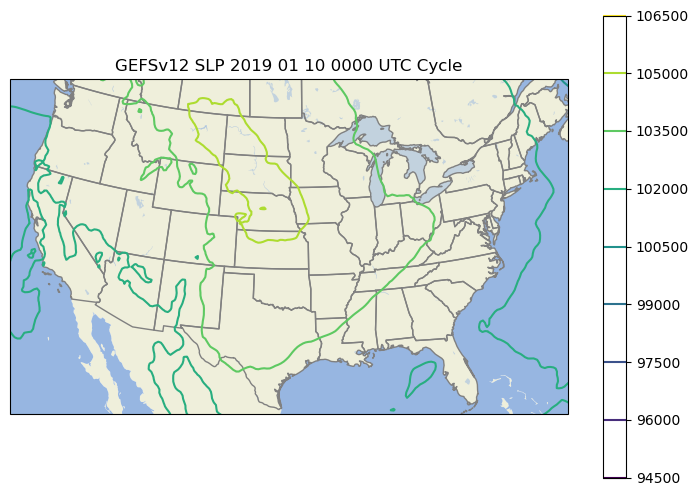

In [10]:
# example for plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')
ax.set_extent([-120, -73, 23, 50])

plt.contour(
    dataset.variables['lon'][:],     # longitudes
    dataset.variables['lat'][:],     # latitudes
    dataset.variables['msl'][0,:,:], # actual data
    transform = cartopy.crs.PlateCarree()) #, levels=np.arange(30000,110000,20000))

plt.title('GEFSv12 SLP 2019 01 10 0000 UTC Cycle')
plt.colorbar()
plt.show()

# Execute Online Training

In [11]:
# parameters for pm
years = ["2018"] #, "2019", "2020"]
months = ["07", "08"] 
days = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", 
        "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"] # forecasts are 10 days long, so (01, 10, 20) provides converage of whole year.

In [ ]:
for y in years:
    for m in months:
        for d in days:
            pm.execute_notebook(
                'CVAE_training.ipynb',
                'CVAE_log.ipynb',
                parameters = dict(year = y, month = m, day = d),
                kernel_name = 'cvae_env'
                
            )

Executing:   7%|▋         | 1/14 [00:00<00:12,  1.01cell/s]2024-07-08 08:21:32.146715: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 08:21:32.192618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 08:21:32.192668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 08:21:32.195064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 

In [ ]:
# Try different filter sizes
# Aim for large initial filter > 200km scale (about 10)
# Aim for some, but minimal overlap in initial filter.

# Aim for smallish second filter, but still try to reduce dimensionality
# to make dense network tractable later. No overlap (but no good
# reason why this is).

# ----------------------Input: 721 x 1440--------------

# For Lat = 721,
# K = 11 -> K_radius = 5.0 -> S = 9 -> H_out = 79.0

# For Lon = 1440,
# K = 11 -> K_radius = 5.0 -> S = 10 -> H_out = 143.0

# -----------------------Layer1: 79 x 143----------------

# For Lat = 79,
# K = 5 -> K_radius = 2.0 -> S = 5 -> H_out = 15.0

# For Lon = 143,
# K = 9 -> K_radius = 4.0 -> S = 9 -> H_out = 15.0

'''
H_in = 1440
P = 0
K_list = [3, 5, 7, 9, 11, 13, 15]                    # Kernel size
S_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] # Stride

for K in K_list:
    for S in S_list:
        K_radius = np.floor(np.divide(K, 2))   # Half width of number of points around the central point
        K_diameter = K - 1                     # Number of points around the central point, ASSUMES K = ODD
        # S = K                                # S = K is stride necessary to have non-overlapping filters
        print('K = ' + str(K) + ' -> K_radius = ' + str(K_radius) + ' -> S = ' + str(S) + ' -> H_out = ' + str((H_in + (2 * P) - K_diameter) / S))
    print('')
'''

# Display a grid of sampled digits

In [ ]:
# if latent_dim == 2:
#     plot_latent_space(vae, path = os.path.join(model_dir, 'latent_space.png'))

# # Generating new images
# codings = tf.random.normal(shape = [12, latent_dim])
# images = vae.decoder(codings).numpy()
# plot_images(images, 3, 4, path = os.path.join(model_dir, 'generated.png'))

# # Semantic interpolation
# codings_grid = tf.reshape(codings, [1, 3, 4, latent_dim])
# larger_grid = tf.image.resize(codings_grid, size = [5, 7])
# interpolated_codings = tf.reshape(larger_grid, [-1, latent_dim])
# images = vae.decoder(interpolated_codings).numpy()
# plot_images(images, 5, 7, path = os.path.join(model_dir, 'interpolated.png'))

In [ ]:
# plot_latent_space(vae)

# Display how the latent space clusters different digit classes

In [ ]:
# def plot_label_clusters(vae, data, labels):
#     # display a 2D plot of the digit classes in the latent space
#     z_mean, _, _ = vae.encoder.predict(data)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()


# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train, y_train)